# RL Figure: 2D Turbulence Snapshot

In [1]:
using JLD2, Interpolations, Statistics, ForwardDiff, OrdinaryDiffEq

const n = 512 # grid resolution 
const L = 2π  # domain length           

##### Load Velocity Field #####
file = jldopen("../../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"][:,:,1]
v_data = file["vel_y"][:,:,1]
vort_data = file["vort"][:,:,1]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

vort(x,y) = etp_vort(n*x/L+1, n*y/L+1)
velX(x,y) = etp_u(n*x/L+1, n*y/L+1)
velY(x,y) = etp_v(n*x/L+1, n*y/L+1)

##### Start, End #####
xA = 1.2
yA = 5.5
rA = 0.2

xB = 5.2
yB = 1.8
rB = 0.2

N_tile = 30 
δ = L/N_tile # grid size for tiling

u0 = maximum(sqrt.(u_data.^2+v_data.^2)) # background maximum velocity
Va = 0.3*u0 # agent's velocity
Δt = δ/(2*u0) # agent's reaction time
Na = 8 # number of actions

n_episodes = 5000 # number of episodes for evaluation
n_train = 100000 # number of episodes for training

T_free = sqrt((xB-xA)^2+(yB-yA)^2)/Va
T_max = 5*T_free

w_reward = 1.0 # weight in the reward function

# optimal trajectory

##### Derivatives #####
velX_x(x,y) = ForwardDiff.derivative(z -> velX(z, y), x)
velX_y(x,y) = ForwardDiff.derivative(z -> velX(x, z), y)
velY_x(x,y) = ForwardDiff.derivative(z -> velY(z, y), x)
velY_y(x,y) = ForwardDiff.derivative(z -> velY(x, z), y)

function TURB_advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*velX(x,y) + Va*T*cos(z)
    du[2] = dy = T*velY(x,y) + Va*T*sin(z)
    du[3] = dz = T*(velY_x(x,y)*sin(z)*sin(z) - velX_y(x,y)*cos(z)*cos(z) + sin(z)*cos(z)*(velX_x(x,y)-velY_y(x,y)))
end

# Simulation interval and intermediary points
tspan_opt = (0.0, 1.0)
tsteps_opt = 0.0:0.001:1.0

p_opt = [-0.8836008560984615, 0.8199981595228619]

prob_opt = ODEProblem(TURB_advection!, [xA, yA, p_opt[1]], tspan_opt, p_opt)
opt_solution = solve(prob_opt, Tsit5(), p = p_opt, saveat = tsteps_opt,
                    reltol = 1e-15, abstol = 1e-15)

times = range(0, 1, length=200)
x_opt = [opt_solution(t)[1] for t in times]
y_opt = [opt_solution(t)[2] for t in times]

nothing

In [2]:
# load data from files
using JLD2

q_data = jldopen("../../Q-learning/2D Turbulence/Q_data_snap.jld2")
ac_data = jldopen("../../Actor-Critic/2D Turbulence/AC_data_snap.jld2")
tp_data = jldopen("../../../Trivial Strategy/2D Turbulence/TP_data.jld2")

nothing

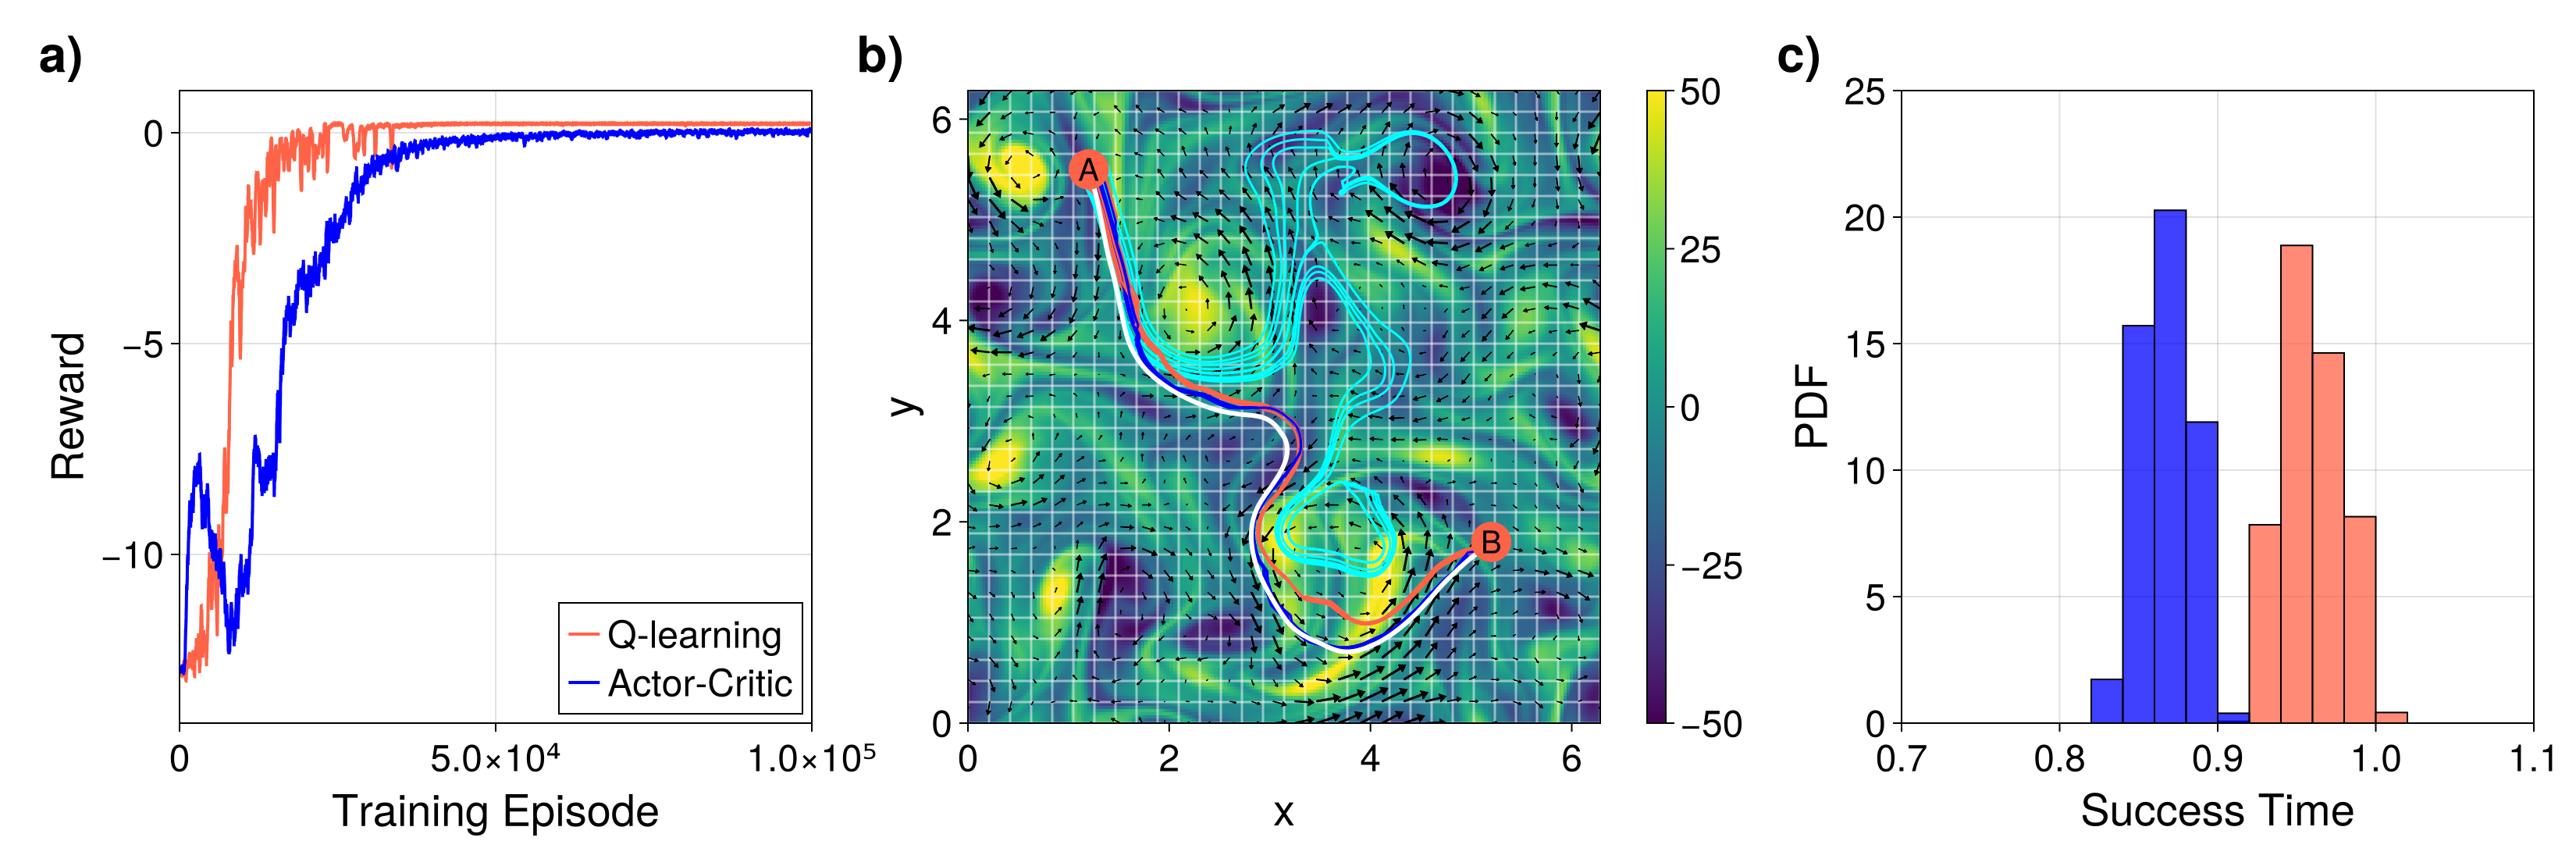

In [4]:
using CairoMakie

moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

fig = Figure(size = (1650, 550), fontsize=24)

ax1 = Axis(fig[1, 1],
    xlabel = "Training Episode", xlabelsize=28, xticklabelsize=24,
    ylabel = "Reward", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, 1.0*n_train), (-14, 1))
)

lines!(ax1, moving_average(q_data["r_tracks"],250), color=:tomato, label="Q-learning", linewidth=2)
lines!(ax1, moving_average(ac_data["r_tracks"],250), color=:blue, label="Actor-Critic", linewidth=2)

axislegend(ax1, position = :rb, fontsize=20)

Label(fig[1, 1, TopLeft()], "a)",
        fontsize = 32,
        font = :bold,
        padding = (0, 50, 5, 0),
        halign = :right)

#################################

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = [vort(x,y) for x in xs, y in ys]

xs2 = LinRange(0, L, N_tile)
ys2 = LinRange(0, L, N_tile)
us2 = [velX(x,y) for x in xs2, y in ys2]
vs2 = [velY(x,y) for x in xs2, y in ys2]

ax2 = Axis(fig[1, 2],
    xlabel = "x", xlabelsize=28, xticklabelsize=24,
    ylabel = "y", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0, L), (0, L)), xticks=[0,2,4,6], yticks=[0,2,4,6]
)

hm = heatmap!(ax2, xs, ys, zs, colorrange=(-50, 50), colormap = :viridis, alpha=1.0)
Colorbar(fig[1, 3], hm, ticklabelsize=24, tellheight=true, ticks=[-50,-25,0,25,50])

rowsize!(fig.layout, 1, ax2.scene.viewport[].widths[2])

hlines!(ax2, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)
vlines!(ax2, LinRange(0, L, N_tile+1), color=:white, alpha=0.5)

arrows2d!(ax2, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

for i in 1:10
    lines!(ax2, tp_data["x_tracks_TP"][i], tp_data["y_tracks_TP"][i], color=:cyan)
end

for i in 1:10
    lines!(ax2, q_data["x_tracks_EV"][i], q_data["y_tracks_EV"][i], color=:tomato)
    lines!(ax2, ac_data["x_tracks_EV"][i], ac_data["y_tracks_EV"][i], color=:blue)
end

lines!(ax2, x_opt, y_opt, color=:white, linewidth=3)

poly!(ax2, Circle(Point2f(xA, yA), rA), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center), fontsize=20)

poly!(ax2, Circle(Point2f(xB, yB), rB), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center), fontsize=20)

Label(fig[1, 2, TopLeft()], "b)",
        fontsize = 32,
        font = :bold,
        padding = (0, 30, 5, 0),
        halign = :right)

####################################

ax3 = Axis(fig[1, 4],
    xlabel = "Success Time", xlabelsize=28, xticklabelsize=24,
    ylabel = "PDF", ylabelsize=28, yticklabelsize=24,
    aspect = 1, limits = ((0.7, 1.1), (0,25))
)

hist!(ax3, q_data["times_EV"], normalization = :pdf, bins=0.7:0.02:1.1, strokewidth = 1,
        strokecolor = :black, color=(:tomato,0.75))

hist!(ax3, ac_data["times_EV"], normalization = :pdf, bins=0.7:0.02:1.1, strokewidth = 1,
        strokecolor = :black, color=(:blue, 0.75))

Label(fig[1, 4, TopLeft()], "c)",
        fontsize = 32,
        font = :bold,
        padding = (0, 40, 5, 0),
        halign = :right)

save("RL_2d_turb_snap.pdf", fig)
fig